In [1]:
%matplotlib inline
# %matplotlib notebook
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
import h5py
import pandas as pd
import numpy as np
import matplotlib
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio.plot 
import datetime

In [2]:
def get_gaussian_kernel(fs_x, fs_y, sigma):
    """
    Create a 2D gaussian kernel
    :param fs_x: filter width along x axis
    :param fs_y: filter width along y axis
    :param sigma: gaussian width
    :return: 2D Gaussian filter of [fs_y x fs_x] dimension
    """
    gaussian_kernel_x = cv2.getGaussianKernel(ksize=np.int(fs_x), sigma=sigma)
    gaussian_kernel_y = cv2.getGaussianKernel(ksize=np.int(fs_y), sigma=sigma)
    gaussian_kernel = gaussian_kernel_y * gaussian_kernel_x.T
    return gaussian_kernel

In [3]:
def get_density_map_gaussian(points, d_map_h, d_map_w):
    """
    Creates density maps from ground truth point locations
    :param points: [x,y] x: along width, y: along height
    :param d_map_h: height of the density map
    :param d_map_w: width of the density map
    :return: density map
    """

    im_density = np.zeros(shape=(d_map_h,d_map_w), dtype=np.float32)

    if np.shape(points)[0] == 0:
        sys.exit()
    for i in range(np.shape(points)[0]):

        f_sz = 15
        sigma = 4

        gaussian_kernel = get_gaussian_kernel(f_sz, f_sz, sigma)

        x = min(d_map_w, max(1, np.abs(np.int32(np.floor(points[i][0])))))
        y = min(d_map_h, max(1, np.abs(np.int32(np.floor(points[i][1])))))

        if(x > d_map_w or y > d_map_h):
            continue

        x1 = x - np.int32(np.floor(f_sz / 2))
        y1 = y - np.int32(np.floor(f_sz / 2))
        x2 = x + np.int32(np.floor(f_sz / 2))
        y2 = y + np.int32(np.floor(f_sz / 2))

        dfx1 = 0
        dfy1 = 0
        dfx2 = 0
        dfy2 = 0

        change_H = False

        if(x1 < 1):
            dfx1 = np.abs(x1)+1
            x1 = 1
            change_H = True

        if(y1 < 1):
            dfy1 = np.abs(y1)+1
            y1 = 1
            change_H = True

        if(x2 > d_map_w):
            dfx2 = x2 - d_map_w
            x2 = d_map_w
            change_H = True

        if(y2 > d_map_h):
            dfy2 = y2 - d_map_h
            y2 = d_map_h
            change_H = True

        x1h = 1+dfx1
        y1h = 1+dfy1
        x2h = f_sz - dfx2
        y2h = f_sz - dfy2

        if (change_H == True):
            f_sz_y = np.double(y2h - y1h + 1)
            f_sz_x = np.double(x2h - x1h + 1)

            gaussian_kernel = get_gaussian_kernel(f_sz_x, f_sz_y, sigma)

        im_density[y1-1:y2,x1-1:x2] = im_density[y1-1:y2,x1-1:x2] +  gaussian_kernel
    return im_density

In [4]:
def get_coordenadas(raster,puntos,url_salida,nombre):
    pixeles = pd.DataFrame(columns=['x', 'y'])
    for index in range(puntos.shape[0]):
        pl = raster.index(puntos["geometry"][index].bounds[0],puntos["geometry"][index].bounds[1])
        pixeles.loc[index] = [pl[0],pl[1]]
    
    pixeles.to_csv(url_salida+"/"+nombre+".csv")
    return pixeles
        

In [6]:
# url_imagen = '/home/diego/Proyecto Vivero/data/01_VIVERO/01_imagenes/imagen_mesones_rgb.tif'
# shp = '/home/diego/Proyecto Vivero/data/01_VIVERO/02_puntos_plantas/plantas_mesones_2.shp'
# url_salida = "/home/diego/Proyecto Vivero/train2"
url_imagen = 'D:/Memoria/Codigo/AraucoNursery/PROYECTOS/VIVERO/imagenes/rotado_cortado.tif'
shp = 'D:/Memoria/Codigo/AraucoNursery/PROYECTOS/VIVERO/puntos_rotados/test.shp'
url_salida = "D:/Memoria/Codigo/AraucoNursery/train/"+str(datetime.datetime.now().day)+"/"
url_salida_png = "D:/Memoria/Codigo/AraucoNursery/train/"+str(datetime.datetime.now().day)+"/png/"
url_salida_tiff = "D:/Memoria/Codigo/AraucoNursery/train/"+str(datetime.datetime.now().day)+"/tiff/"
archivo_h5_cuentas = url_salida+'/data_cuentas.h5'
archivo_h5_mapa = url_salida+'/data_mapa.h5'

In [7]:
if not os.path.exists(url_salida):
    os.makedirs(url_salida)
if not os.path.exists(url_salida_png):
    os.makedirs(url_salida_png)
if not os.path.exists(url_salida_tiff):
    os.makedirs(url_salida_tiff)

In [8]:
puntos = gpd.read_file(shp)
raster = rasterio.open(url_imagen)

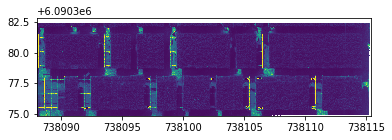

In [9]:
rasterio.plot.show(raster)

In [10]:
coordenadas = []
csv = get_coordenadas(raster,puntos,url_salida,"pixeles")
# csv = pd.read_csv(url_salida+"/pixeles.csv")
for element in range(csv.shape[0]):
    coordenadas.append([csv["y"][element],csv["x"][element]])

In [11]:
mapa_densidad = get_density_map_gaussian(coordenadas,raster.height,raster.width)

(588, 2011)


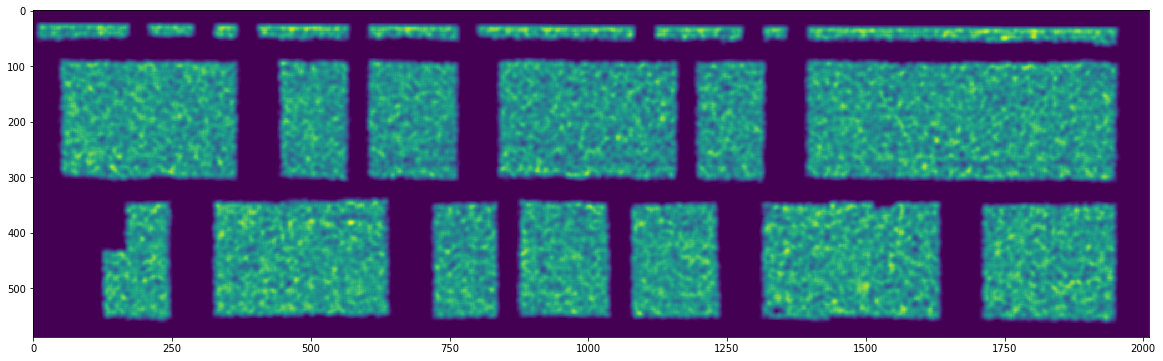

In [12]:
plt.figure(figsize=(20,15))
print(mapa_densidad.shape)
plt.imshow(mapa_densidad)
plt.show()

In [14]:
mapa_densidad.tofile(url_salida+"/mapa_densidad.txt")

In [37]:
offsetX = 0
offsetY = 0
width = 100
height = 100
step = 10
nulo = [65535]
lista_imagenes = []
lista_etiquetas = []
lista_mapa = []
contador = 0

In [38]:
%%time
contador = 0
out_meta = raster.meta.copy()
while (1):
        # finalizar si se a recorrido toda la imagen
    if(offsetY >= raster.height and offsetX >= raster.width):
        break
     #cuando llegue al borde en el eje x, debo bajar(sumar en eje y) y debo volver a empezar setear offsetX en 0 y widthX en 100
    elif(offsetX >= raster.width):
        offsetY = offsetY + step
        offsetX = 0
   
    #entregamos los pixeles para obtener las coordenadas
    t = raster.xy(offsetX, offsetY)
    l = raster.xy(offsetX + width , offsetY)
    r = raster.xy(offsetX, offsetY + height)
    b = raster.xy(offsetX + width , offsetY + height)  
    bbox = box(l[0], b[1], r[0], t[1])
        
    try:
        #transformacion de la imagen
        out_img, out_transform = mask(raster, shapes=[bbox], crop=True)
        valores = np.unique(out_img)
        # si solo se tiene valores NODATA en la imagen, la descartamos
        
        if np.array_equal(valores,nulo):
            offsetX = offsetX + step
#             contador = contador + 1
            continue
    
        # quitamos pixeles irrelevantes
        
        out_png = out_img[0:3,0:100,1:101]
        out_img = out_img[:,0:100,1:101]
        
        if(out_png.shape != (3, 100, 100)):
            offsetX = offsetX + step
            continue
        

        out_meta.update(  {"driver": "GTiff",
                   "height": 100,
                    "width": 100,
                    "transform": out_transform,
                    "crs": raster.crs})
        lista_imagenes.append(out_png)
                #corte mapa densidad
        corte= mapa_densidad[offsetX: offsetX + width , offsetY : offsetY + height]
        lista_mapa.append(corte)
        

        #interseccion ptos
        interseccion = puntos["geometry"].intersects(bbox)
        cantidad = interseccion.value_counts()
        
        if(True in cantidad.index):
            numero = cantidad[True]
            mpimg.imsave('{}/salida{}.png'.format(url_salida_png,contador), out_png.T)
            with rasterio.open('{}/salida{}.tif'.format(url_salida_tiff,contador), "w", **out_meta) as dest:
                dest.write(out_img)

        else:
            numero = 0
        lista_etiquetas.append(numero)
        
    except ValueError:
        pass
    contador = contador + 1
    offsetX = offsetX + step 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Wall time: 10min 8s


In [39]:
contador = 0
for element in lista_imagenes:
    if(element.shape !=(3,100,100)):
        print(contador,element.shape)
    contador += 1 
#     print()

In [44]:
lista_imagenes[157].shape

(3, 100, 100)

In [45]:
n_lista_imagenes = len(lista_imagenes)
n_lista_etiquetas = len(lista_etiquetas)
n_lista_mapa = len(lista_mapa)

In [46]:
n_lista_imagenes,n_lista_etiquetas,n_lista_mapa

2940

In [57]:
lista_imagenes = np.array(lista_imagenes)
lista_etiquetas = np.array(lista_etiquetas)
lista_mapa = np.array(lista_mapa)

In [58]:
HEIGHT = 100
WIDTH = 100
CHANNELS = 3
hf = h5py.File(archivo_h5_cuentas, 'w')

In [59]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

Wall time: 41.4 s


In [60]:
Yset = hf.create_dataset(
        name= "counts",
        data=lista_etiquetas,
        shape=(n_lista_etiquetas,),
        compression="gzip",
        compression_opts=9)

In [61]:
hf.close()

In [62]:
hf = h5py.File(archivo_h5_mapa, 'w')

In [63]:
%%time
Xset = hf.create_dataset(
        name= "images",
        data=lista_imagenes,
        shape=(n_lista_imagenes,HEIGHT, WIDTH, CHANNELS),
        compression="gzip",
        compression_opts=9)

Wall time: 42.7 s


In [64]:
Yset = hf.create_dataset(
        name= "density",
        data=lista_mapa,
        shape=(n_lista_mapa,HEIGHT,WIDTH),
        compression="gzip",
        compression_opts=9)

In [65]:
hf.close()